Derive spec2vec embeddings of MS/MS spectra

In [17]:
import os
import sys
import gensim
import numpy as np

ROOT = os.path.dirname(os.getcwd())
#path_data = os.path.join(ROOT, 'data')
path_data = 'C:\\Users\\Gosia\\Desktop\\'
sys.path.insert(0, ROOT)

In [18]:
from matchms.importing import load_from_json
spectrums_lib = []
path_lcms = 'C:\\Users\\Gosia\\Desktop\\gnps_from_simon'
counter = 0
for s in os.listdir(path_lcms):
    if counter <= 5: 
        spectrums_lib += load_from_json(os.path.join(path_lcms,s))
        counter += 1

In [19]:
from matchms.filtering import normalize_intensities
from matchms.filtering import require_minimum_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import add_losses
def post_process_s2v(s):
    
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = require_minimum_number_of_peaks(s, n_required=10)
    s = reduce_to_number_of_peaks(s, n_required=10, ratio_desired=0.5)
    if s is None:
        return None
    s_remove_low_peaks = select_by_relative_intensity(s, intensity_from=0.001)
    if len(s_remove_low_peaks.peaks) >= 10:
        s = s_remove_low_peaks
        
    s = add_losses(s, loss_mz_from=5.0, loss_mz_to=200.0)
    return s

In [20]:
# apply post processing steps to the data

spectrums_lib = [post_process_s2v(s) for s in spectrums_lib]

# omit spectrums that didn't qualify for analysis

spectrums_lib = [s for s in spectrums_lib if s is not None]


Create spectrum "documents"

In [32]:
from spec2vec import Spec2Vec
from spec2vec import SpectrumDocument

documents_lib = [SpectrumDocument(s, n_decimals=2) for s in spectrums_lib]


In [37]:
from spec2vec.model_building import train_new_word2vec_model
path_models = os.path.join(path_data, "trained_models")

model_file = os.path.join(path_models, "spec2vec_librarymatching_size_2.model")

iterations = [1, 3, 5, 10]

#Train model with size 10 and default parameters

model = train_new_word2vec_model(documents_lib, iterations, model_file, size = 2)

The value of size is set from 300 (default) to 2
  Epoch 1 of 10.Change in loss after epoch 1: 125453.3515625
Saving model with name: C:\Users\Gosia\Desktop\trained_models\spec2vec_librarymatching_size_2_iter_1.model
  Epoch 2 of 10.Change in loss after epoch 2: 125885.8359375
  Epoch 3 of 10.Change in loss after epoch 3: 119433.46875
Saving model with name: C:\Users\Gosia\Desktop\trained_models\spec2vec_librarymatching_size_2_iter_3.model
  Epoch 4 of 10.Change in loss after epoch 4: 96663.5625
  Epoch 5 of 10.Change in loss after epoch 5: 87828.09375
Saving model with name: C:\Users\Gosia\Desktop\trained_models\spec2vec_librarymatching_size_2_iter_5.model
  Epoch 6 of 10.Change in loss after epoch 6: 85036.25
  Epoch 7 of 10.Change in loss after epoch 7: 85173.125
  Epoch 8 of 10.Change in loss after epoch 8: 83157.625
  Epoch 9 of 10.Change in loss after epoch 9: 82244.0625
  Epoch 10 of 10.Change in loss after epoch 10: 78672.1875
Saving model with name: C:\Users\Gosia\Desktop\trai


Derive embeddings

In [38]:
from tqdm.notebook import tqdm  # optional, just to get a progress bar
from spec2vec.vector_operations import calc_vector


intensity_weighting_power = 0.5
allowed_missing_percentage = 15 # specify the maximum (weighted) fraction of the spectrum that is allowed to be missing

vector_size = model.vector_size
print(f"Embedding vector size: {vector_size}")

embeddings_spec2vec_lib = np.zeros((len(documents_lib), vector_size), dtype="float")
for i, doc in enumerate(tqdm(documents_lib)):
    embeddings_spec2vec_lib[i, 0:vector_size] = calc_vector(model, doc,
                                                        intensity_weighting_power,
                                                        allowed_missing_percentage)

Embedding vector size: 2


In [39]:
print([np.round(x, 4) for x in embeddings_spec2vec_lib])

[array([228.0165, -71.1646]), array([117.5889, -35.9902]), array([13.3868, -2.9193]), array([25.4001, -5.4501]), array([216.5385, 194.3738]), array([ 52.0993, -13.3444]), array([19.566 , -4.4484]), array([227.4235,  39.2623]), array([21.1608, -3.2236]), array([ 7.1504, -1.8883]), array([212.8983, 150.692 ]), array([ 7.4354, -1.2929]), array([20.8578, -1.5707]), array([42.3785, 12.0125]), array([111.84  , -27.2316]), array([115.4945,  70.4912]), array([16.8118, -2.3949]), array([193.1963, -59.4122]), array([88.6557, -3.1572]), array([35.3223, -1.793 ]), array([ 81.938 , -18.2928]), array([13.0371, -1.8859]), array([96.9277, 29.0414]), array([ 38.4117, -11.6533]), array([ 68.6636, -21.2859]), array([ 8.6673, -0.7645]), array([136.6953, 111.3457]), array([ 7.6328, -0.2467]), array([60.4245, 13.2308]), array([17.4109, -3.3295]), array([169.1861, -20.1385]), array([17.5599, -8.7887]), array([94.7811, -4.5844]), array([ 28.5023, -10.8938]), array([109.4277,  -7.9549]), array([12.986 , -0.781

In [47]:
print(mu)

[[228.01653761]
 [-71.16463633]]


# Creating knockoffs


<ipython-input-50-f4ae8f2ad171>:39: UserWarning: No contour levels were found within the data range.
  CS = plt.contour(xi,yi,zi,6,linewidths=0.5,colors='k')
<ipython-input-50-f4ae8f2ad171>:68: UserWarning: No contour levels were found within the data range.
  CS = plt.contour(xi, yi, zi, 6, linewidths=0.5, colors='r')


True
0.14775524709937599
0.14775524709937596
0.14775524709937596


(-73.16463633060324, -69.16463633060324)

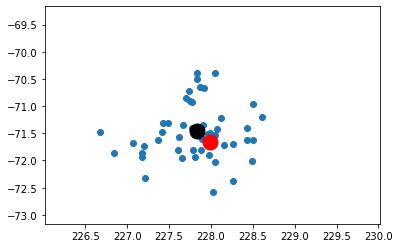

In [50]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import numpy.ma as ma
from numpy.random import uniform, seed
from matplotlib import cm
def gauss(x,y,Sigma,mu):
    X=np.vstack((x,y)).T
    mat_multi=np.dot((X-mu[None,...]).dot(np.linalg.inv(Sigma)),(X-mu[None,...]).T)
    return  np.diag(np.exp(-1*(mat_multi)))

def get_c(x,y,z):
    # define grid.
    xi = np.linspace(0,4,1000)
    yi = np.linspace(-2.,3.,1000)
    ## grid the data.
    zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')
    return xi,yi,zi


def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)


# seed(1234)

# define the mean and covariance 
mu = np.array([embeddings_spec2vec_lib[0]]).T
Sigma = np.asarray([[1.,.8],[0.8,1.]])
npts = 1000
# make some x and y and z for the contour
x = uniform(mu[0]-2,mu[0]+2,npts)
y = uniform(mu[1]-2,mu[1]+2,npts)
z = gauss(x,y,Sigma=Sigma,mu=mu.flatten())
xi, yi, zi = get_c(x,y,z)
zi[np.isnan(zi)] = 0
zi[zi<1e-3] = 0
plt.figure()
CS = plt.contour(xi,yi,zi,6,linewidths=0.5,colors='k')



# generate a sample
point = np.random.multivariate_normal(mu.flatten(),Sigma,1)
plt.plot(point[0][0], point[0][1], 'ro', markersize=15)

D = np.eye(2)*0.13

joint_cov = np.hstack((Sigma, Sigma-D))
joint_cov = np.vstack((joint_cov, np.hstack((Sigma-D,Sigma))))

print(is_pos_def(joint_cov))

# generate N knock-offs
kmu = np.dot(np.dot(D,np.linalg.inv(Sigma)),mu)
A = np.eye(2) - np.dot(D,np.linalg.inv(Sigma))
B = np.dot(A, point.T)
kmu += B
kSigma = 2*D - np.dot(np.dot(D,np.linalg.inv(Sigma)), D)
kk = np.random.multivariate_normal(kmu.flatten(), kSigma, 50)
plt.scatter(kk[:,0],kk[:,1])

z = gauss(x,y, Sigma=kSigma, mu = kmu.flatten())
xi, yi, zi = get_c(x, y, z)

zi[np.isnan(zi)] = 0
zi[zi<1e-3] = 0
CS = plt.contour(xi, yi, zi, 6, linewidths=0.5, colors='r')

# check some things
joint_mu = np.vstack((mu,mu))

# take a random knockoff
n = np.random.randint(50)
plt.plot(kk[n,0],kk[n,1],'ko', markersize=15)
kkk = kk[n,:][:,None]
stacked = np.vstack((point.T,kkk))

from scipy.stats import multivariate_normal

mvn = multivariate_normal(mean = joint_mu.flatten(), cov = joint_cov)
print(mvn.pdf(stacked.flatten()))
# swap to test that p is the same
# swap first element of original with first of knock-off
temp = stacked[0][0]
stacked[0][0] = stacked[2][0]
stacked[2][0] = temp
print(mvn.pdf(stacked.flatten()))
# swap second with second
temp = stacked[1][0]
stacked[1][0] = stacked[3][0]
stacked[3][0] = temp
print(mvn.pdf(stacked.flatten()))


plt.xlim([mu[0]-2,mu[0]+2])
plt.ylim([mu[1]-2,mu[1]+2])

In [11]:
import gensim
from sklearn.mixture import GaussianMixture as GMM
from sklearn.datasets import make_spd_matrix
from spec2vec import calc_vector

In [12]:
#Fitting Gaussian mixture model with 25 components, full covariance structure

gmm = GMM(n_components=25, covariance_type="full")
model = gmm.fit(np.array(embeddings_spec2vec_lib))


In [13]:
#Finding Dk matrix in sampling process

def find_Dk(covariance_matrix, embedding_dimension):
    
    eigs = np.linalg.eig(covariance_matrix)[0]
    min_eig = min(eigs)
    s = min(2*min_eig, 1)
    Dk = np.diag([s]*embedding_dimension)
    return Dk
               
def is_pos_semi_def(A, epsilon = 1e-10):    
    eigs = np.linalg.eig(A)[0]
    min_eig = min(eigs)
    return min_eig >= -epsilon

In [14]:
def create_knockoffs(model,vectors):
    embedding_dimension = len(vectors[0])
    covariances = model.covariances_
    means = model.means_
    Dks = []
    for cov in covariances:
        cov = np.asarray([[1.,.8],[0.8,1.]])
        Dk = find_Dk( cov, embedding_dimension )
        if not is_pos_semi_def( 2*cov-Dk ):
            return
        Dks.append(Dk)

    knock_means_comps_1 = []
    knock_means_comps_2 = []
    knock_covs = []
    Id = np.diag([1]*embedding_dimension)
    for cov,mean,Dk in zip(covariances,means,Dks):
        cov = np.asarray([[1.,.8],[0.8,1.]])
        knock_cov = 2*Dk - Dk@(cov@Dk)
        knock_mean_comp_1 = Dk@(cov@mean)
        knock_mean_comp_2 = Id - Dk@cov
        knock_means_comps_1.append(knock_mean_comp_1)
        knock_means_comps_2.append(knock_mean_comp_2)
        knock_covs.append(knock_cov)
        
    knockoffs = []
    bad_is = []
    components = np.arange(len(model.weights_))
    probs = model.predict_proba(vectors)
    for i, x in enumerate(vectors):        
        x_probs = probs[i]
        k_posterior = np.random.choice(components, p=x_probs)
        knock_mean = knock_means_comps_1[k_posterior] + knock_means_comps_2[k_posterior]@x
        knock_cov = knock_covs[k_posterior]
        if i and not i%100:
            print( 'trying',i )
        if not is_pos_semi_def(knock_cov):
            bad_is.append(i)
            continue
        try:
            knockoff_sample = np.random.multivariate_normal(knock_mean, knock_cov)
        except:
            bad_is.append(i)
            continue
        knockoffs.append(knockoff_sample)
        print('success',i)        
    return knockoffs, bad_is 

In [15]:
knockoffs = create_knockoffs(model,np.array(embeddings_spec2vec_lib))

success 0
success 1
success 2
success 3
success 4
success 5
success 6
success 7
success 8
success 9
success 10
success 11
success 12
success 13
success 14
success 15
success 16
success 17
success 18
success 19
success 20
success 21
success 22
success 23
success 24
success 25
success 26
success 27
success 28
success 29
success 30
success 31
success 32
success 33
success 34
success 35
success 36
success 37
success 38
success 39
success 40
success 41
success 42
success 43
success 44
success 45
success 46
success 47
success 48
success 49
success 50
success 51
success 52
success 53
success 54
success 55
success 56
success 57
success 58
success 59
success 60
success 61
success 62
success 63
success 64
success 65
success 66
success 67
success 68
success 69
success 70
success 71
success 72
success 73
success 74
success 75
success 76
success 77
success 78
success 79
success 80
success 81
success 82
success 83
success 84
success 85
success 86
success 87
success 88
success 89
success 90
success 9

In [16]:
for i,j in enumerate([86,88,111,402,462,529]):
    print(knockoffs[0][i],embeddings_spec2vec_lib[j])


[218.63690995 -89.44958162] [429.12582422 483.29134263]
[156.55865123  -5.89939702] [410.5978166  524.25434191]
[12.99764246 -4.4377271 ] [373.45889346 -59.82692615]
[27.59208165 -6.97422291] [432.04787725 414.17598381]
[217.24470074 181.63363614] [406.67820216 273.17724163]
[ 55.631233   -12.92026322] [358.09549963 -82.64726306]
